In [1]:
import h5py as hpy
import numpy as np
from PIL import Image
from PIL import ImageDraw
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import util
import time
import math
import random

from IPython import display

%matplotlib inline

def show_image(array,ch = 1, shape = 256, imtype = None):
    
    if not imtype:
    
        if ch > 1:
            img = np.resize(array,(ch,shape,shape))
            img = np.swapaxes(img,1,2)
            plt.imshow(img.T)
        else:
            img = np.resize(array,(shape,shape))
            plt.imshow(img, cmap='gray')
    else:
        img = np.resize(array,(shape,shape))
#         color_list = plt.cm.Set3(np.linspace(0, 1, 12))
        plt.imshow(img, cmap='gray')
        
        
def visualizationAnimation2(npMatrix1,npMatrix2,num_images = None ,target_shape1 = 1000,target_shape2 = 200, delay = 0.3 ,init=0,
                           skip = 1 , inches = (14.5, 7.5),resize_size1= None, imType = None):
    if not num_images:
        
        if skip == 0:
            num_images = np1Matrix.shape[0]
        else :
            num_images = npMatrix1.shape[0] / skip
            
    for i in range(init,init + num_images*skip,skip):
        
        fig = plt.gcf()
        fig.set_size_inches(inches[0], inches[1])
        plt.subplot(221)
        
        if resize_size1:
            show_image(util.crop_square(npMatrix1[i],target_shape1,resize_size1,(target_shape1-resize_size1)/2),1,resize_size1, imType)
        else:
            show_image(npMatrix1[i],1,target_shape1, imType)
            
        plt.title('Dataset 1 ' +  str(i))
        
        plt.subplot(222)
        show_image(npMatrix2[i],1,target_shape2, imType)
        plt.title('Centered Image '+ str(i))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        time.sleep(delay)
        

        
def test (prior, local, target_shape=500, local_shape=200, 
                            offsetX = None, offsetY = None, rot = 0,
                            prior_image=False, inches=None):

    print 'offsetX: ' + str(offsetX)
    print 'offsetY: ' + str(offsetY)
    print 'theta: ' + str(rot)
    
    fig = plt.gcf()
    if not inches:
        inches = (20,14)        
    fig.set_size_inches(inches[0], inches[1])
    
    offset = (target_shape - local_shape)/2        
    local_big = np.zeros((target_shape,target_shape))    

    local_big[offset:-offset, offset:-offset] = local
#     foreground = Image.fromarray(cm.gray(local_big)*255))
        
    print 'shape'
    print np.asarray(foreground.getdata()).shape
    
    foreground = Image.fromarray(np.float64(local_big))
    foreground = foreground.rotate(90)
    local_big = np.array(foreground.getdata())
    local_big = np.resize(local_big, (target_shape, target_shape))
    foreground = Image.fromarray(np.uint8(cm.gray(local_big)*255))
    print local_big.shape

    plt.imshow(foreground)        
        
def local_over_prior_image (prior, local, target_shape=500, local_shape=200, 
                            offsetX = None, offsetY = None, rot = 0,
                            prior_image=False, inches=None):

    print 'offsetX: ' + str(offsetX)
    print 'offsetY: ' + str(offsetY)
    print 'theta: ' + str(rot)
    
    fig = plt.gcf()
    if not inches:
        inches = (20,14)        
    fig.set_size_inches(inches[0], inches[1])
    
    offset = (target_shape - local_shape)/2        
    local_big = np.zeros((target_shape,target_shape))    
    local_big[offset:-offset, offset:-offset] = local
    
    foreground = Image.fromarray(np.float64(local_big))
    foreground = foreground.rotate(rot)
    local_big = np.array(foreground.getdata())
    local_big = np.resize(local_big, (target_shape, target_shape))

    local_big = np.roll(local_big, offsetX, axis=1)
    local_big = np.roll(local_big, offsetY, axis=0)
#     foreground = Image.fromarray(np.uint32(local_big))
#     foreground = foreground.rotate(90)
#     local_big = np.asarray(foreground.getdata())
#     local_big = np.resize(local_big, (target_shape, target_shape))

    foreground = Image.fromarray(np.uint8(cm.gray(local_big)*255))
#     foreground = foreground.rotate(rot)
    
    if prior_image:
        background = prior
    else:
        background = Image.fromarray(np.uint8(cm.Reds(prior)*255))

#     xmin = offsetX
#     ymax = offsetY
#     xmax = offsetX+local_shape
#     ymin = offsetY-local_shape

# Do translation here
#     foreground = Image.fromarray(np.uint8(local_big))
#     foreground = Image.fromarray(np.uint8(cm.gray(local_big)*255))
#     foreground = Image.fromarray(np.uint8(cm.gray(local_big)*255))
    
    background.putalpha(220)
    flat_l = local_big.flatten()*255

    print np.array(foreground.getdata()).shape # with 4 channels
    print flat_l.shape 
    print flat_l.sum()

    newData = []
    for item in zip(foreground.getdata(),flat_l):
        if item[1] < 10:
            newData.append((0, 0, 0, 0))
        else:
            newData.append((item[0][0], item[0][1],item[0][2],250))
        
    foreground.putdata(newData)
    background.paste(foreground,(0,0),foreground)
    plt.imshow(background)

def get_edges_after_rotation (rotateTheta):
    vertices = np.zeros((2, 4)) # x,y
    edges = np.zeros((2,4)) # m,c for y=mx+c

    vertices[0,:4] = [0, 1000, 1000, 0]
    vertices[1,:4] = [0, 0, -1000, -1000]

    # change angle to radians
    vertices[0,:4], vertices[1,:4] = util.rotate_coords (vertices[0,:4], vertices[1,:4], rotateTheta * np.pi / 180, 500, -500)

    xmin = np.min(vertices[0,:4])
    xmax = np.max(vertices[0,:4])
    ymin = np.min(vertices[1,:4])
    ymax = np.max(vertices[1,:4])

    indices = np.where(vertices[0,:4] == xmin)[0]
    if indices.shape[0] > 1:
        if vertices[1,indices[0]] < vertices[1,indices[1]]:
            xmin_index = indices[0]
        else:
            xmin_index = indices[1]
    else:
        xmin_index = indices[0]
    
    indices = np.where(vertices[1,:4] == ymin)[0]
    if indices.shape[0] > 1:
        if vertices[0,indices[0]] > vertices[0,indices[1]]:
            ymin_index = indices[0]
        else:
            ymin_index = indices[1]
    else:
        ymin_index = indices[0]
    
    indices = np.where(vertices[0,:4] == xmax)[0]
    if indices.shape[0] > 1:
        if vertices[1,indices[0]] > vertices[1,indices[1]]:
            xmax_index = indices[0]
        else:
            xmax_index = indices[1]
    else:
        xmax_index = indices[0]
    
    indices = np.where(vertices[1,:4] == ymax)[0]
    if indices.shape[0] > 1:
        if vertices[0,indices[0]] < vertices[0,indices[1]]:
            ymax_index = indices[0]
        else:
            ymax_index = indices[1]
    else:
        ymax_index = indices[0]

    # all indices different due to rect
#     print 'xmin:' + str(xmin_index)
#     print 'ymax:' + str(ymax_index)
#     print 'xmax:' + str(xmax_index)
#     print 'ymin:' + str(ymin_index)
#     print vertices

    for i in range(4):
        if i == 0:
            v1_index = xmin_index
            v2_index = ymax_index
        elif i == 1:
            v1_index = ymax_index
            v2_index = xmax_index
        elif i == 2:
            v1_index = xmax_index
            v2_index = ymin_index
        else:
            v1_index = ymin_index
            v2_index = xmin_index
        
        if ((vertices[0,v1_index] - vertices[0,v2_index]) == 0):
            m = float('NaN')
            c = 0
        else:
            m = (vertices[1,v1_index] - vertices[1,v2_index]) / ((vertices[0,v1_index] - vertices[0,v2_index])) 
            c = vertices[1,v1_index]-vertices[0,v1_index]*m

#         print 'i:' + str(i)
#         print 'm:' + str(m)
#         print 'c:' + str(c)
        edges[0,i] = m
        edges[1,i] = c

    return edges    
    

In [ ]:
"""
#     xmax_diff = 0
#     ymin_diff = 0
#     ymax_diff = 0
    
#     if xmin < 0:
#         xmin = 0
    
#     if ymax > target_shape:
#         ymax_diff = ymax - target_shape
#         ymax = target_shape
    
#     if ymin < 0:
#         ymin_diff = ymin
#         ymin = 0
    
#     if xmax > target_shape:
#         xmax_diff = xmax - target_shape
#         xmax = target_shape        
        
    if xmax > target_shape:
        xmax = target_shape-xmax
    
    if ymax > target_shape:
        ymax = target_shape-ymax
        
    local_big = np.zeros((target_shape,target_shape))
    local_big[xmin:xmax,ymin:ymax] = local
#     local_big[offsetX:offsetX+local_shape,offsetY-local_shape:local_shape] = local
#     local_big[xmin:xmax,ymin:ymax] = local[xmin-offsetX:local_shape-xmax_diff,ymin_diff:local_shape-ymax_diff]

"""            

In [2]:
File = hpy.File("/media/nikhil/d5c833fe-837f-416d-8de3-fb94e14f0de1/dngv_gdata/downtown/2013-11-20.01/gen/intensity-regression/output_intensity_regression", "r")    

print File.name
for name in File:
    print name

/
local_map
pose
prior_map


In [182]:
prior = File['prior_map']
local = File['local_map']
pose= File['pose']

print prior.shape
print local.shape
print pose.shape

(1000, 1000000)
(1000, 40000)
(1000, 6)


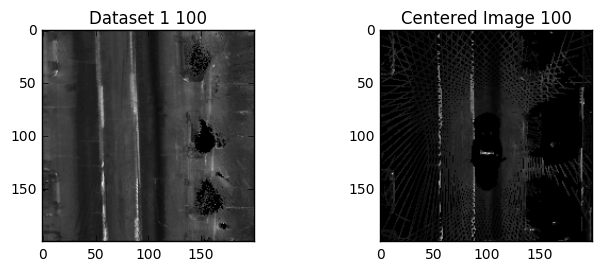

KeyboardInterrupt: 

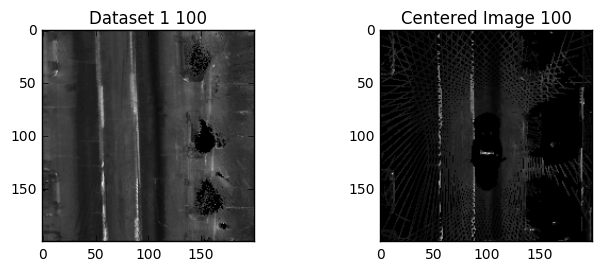

In [4]:
%matplotlib inline
visualizationAnimation2(prior,local, init = 0,skip = 100,delay = 2,inches=(8,6), resize_size1=200)


-0.00960767
(255, 245, 240, 255)
(254, 231, 221, 255)


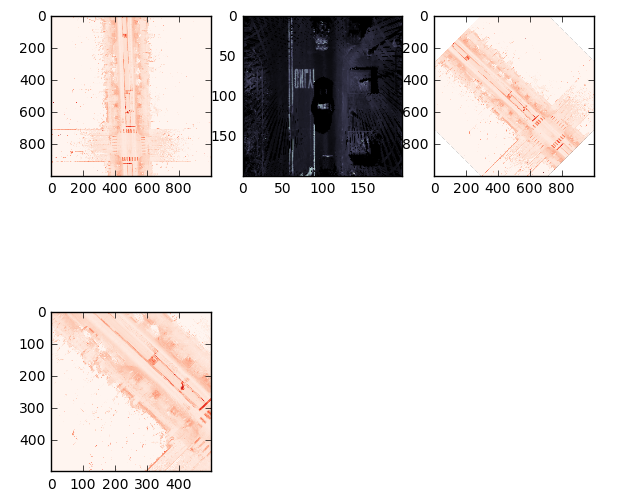

In [5]:
%matplotlib inline

fig = plt.gcf()
inches = (7,7)
fig.set_size_inches(inches[0], inches[1])
#j = 150
#j = 111
j=163

target_shape = 1000
background_intensity = Image.fromarray(np.uint8(cm.Reds(np.resize(prior[j],(target_shape,target_shape)))*255))

base = (250,250)
angle = math.pi/4
target = 500


# sample = diagonal_crop.crop(background_intensity, base, 0, target, target)
sample = background_intensity.rotate(45)
sample_crop = sample.crop((150, 350, 650, 850))

target_shape = 200
foreground_intensity = Image.fromarray(np.uint8(cm.bone(np.resize(local[j],(target_shape,target_shape)))*255))

print pose[j][5]

plt.subplot(231)
plt.imshow(background_intensity)

plt.subplot(232)
plt.imshow(foreground_intensity)

plt.subplot(233)
plt.imshow(sample)

plt.subplot(234)
plt.imshow(sample_crop)

print sample_crop.getpixel((0, 499))
print sample_crop.getpixel((250, 250))

offsetX: None
offsetY: None
theta: 0
shape
(1000000,)
(1000, 1000)


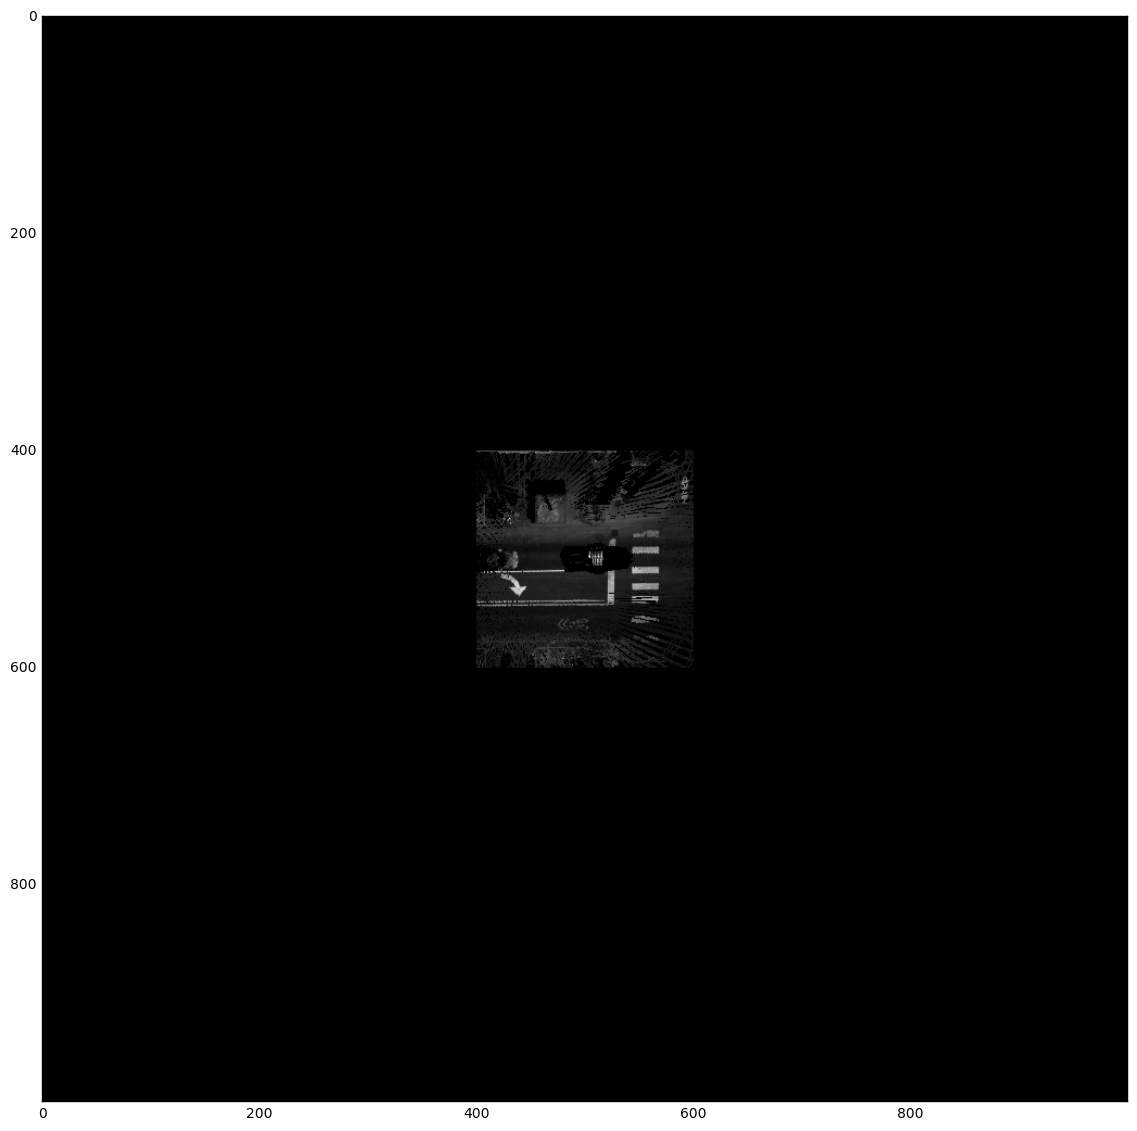

In [55]:
j = 250

target_shape = 1000
local_shape = 200
prior_map = np.resize(prior[j],(target_shape,target_shape))
local_map = np.resize(local[j],(local_shape,local_shape))
test (prior_map, local_map, target_shape=1000, local_shape=200)

offsetX: None
offsetY: None
theta: 0
(1000000, 4)
(1000000,)
1188075.03333


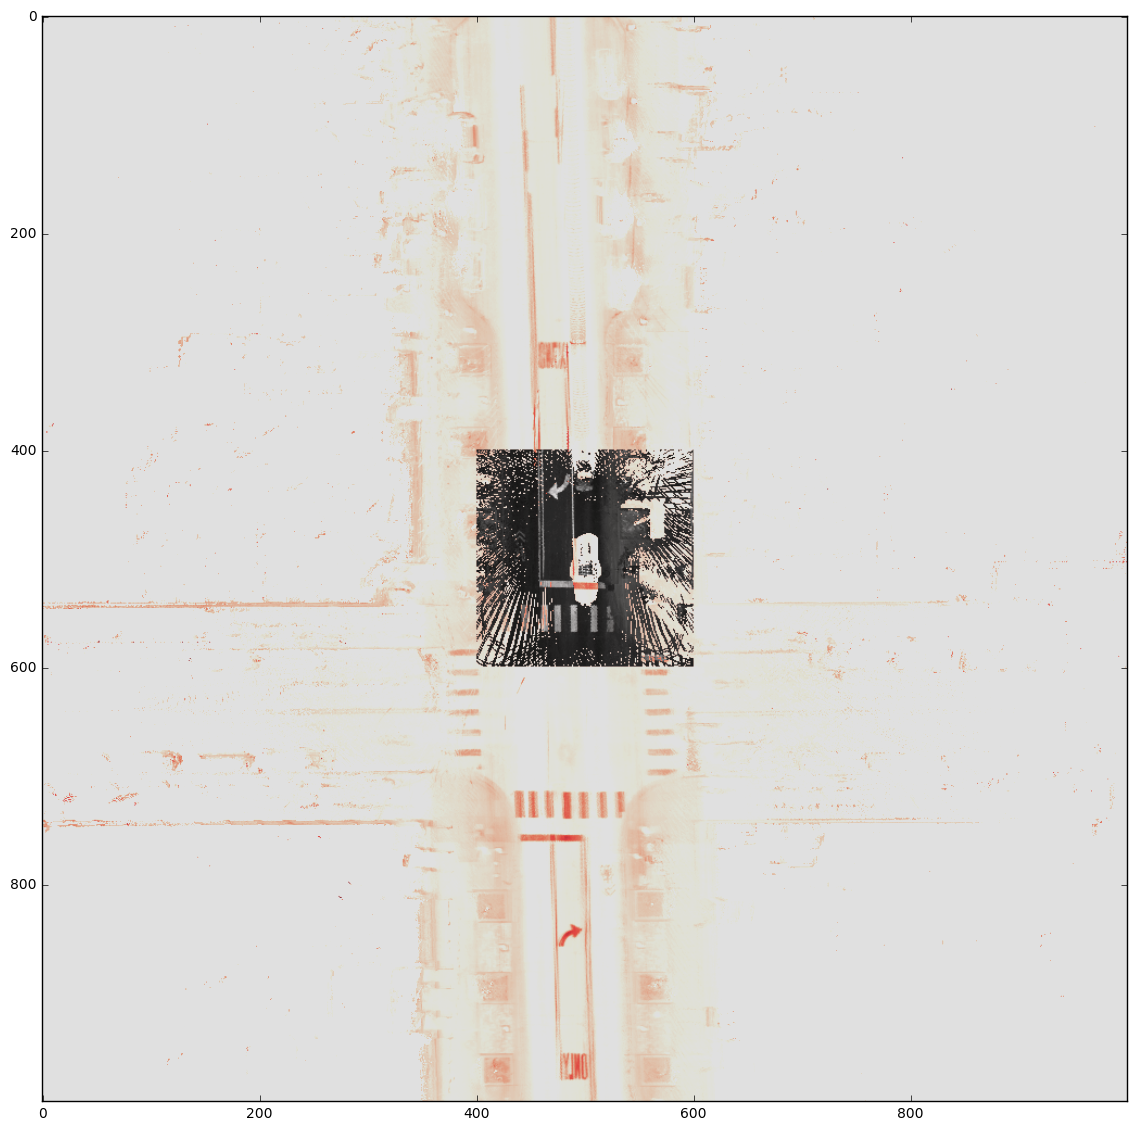

In [57]:
local_over_prior_image (prior_map, local_map, target_shape=1000, local_shape=200)

In [44]:
prior
local
pose
size = prior.shape[0]
initial_y = np.zeros((size, 3))

initial_y[:size, 0] = 500
initial_y[:size, 1] = 500
initial_y[:size, 2] = pose[:size,5]

for i in range(size):
    val = initial_y[i,2]
    if val < 0:
        initial_y[i,2] = val + 2*math.pi
    elif val > 2*math.pi:
        initial_y[i,2] = val - 2*math.pi

        
        
xo = random.randint (-250, 250)
yo = random.randint (-250, 250)
tho = random.uniform (-2*math.pi, 2*math.pi)        




for i in range(size):
    
    
print tho


3.59491268721


0.267949192431
-3.73205080757
newX:342
ymin:-925.999466394
ymax:-524
theta:285
newX:342
newY:627


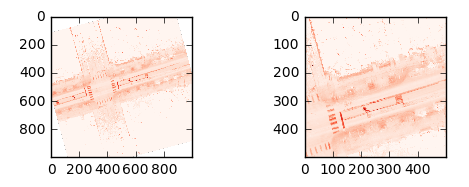

In [184]:
j = 250
background_intensity = np.resize(prior[j],(1000,1000))


rotateTheta = random.randint (0,360)
edges = get_edges_after_rotation(rotateTheta)

# Find what all values can x take for this rotation
# Xmin = Max (X-Intercept with E1 and y=250, X-Intercept with E4 and y=750)
# Xmax = Min (X-Intercept with E2 and y=250, X-Intercept with E3 and y=750)

m1 = edges[0,0]
c1 = edges[1,0]

m2 = edges[0,1]
c2 = edges[1,1]

m3 = edges[0,2]
c3 = edges[1,2]

m4 = edges[0,3]
c4 = edges[1,3]

print m1
print m4

if np.isnan(m1) or m4 == 0:
    xmin = 0
    xmax = 500
else:
    
    x1 = (-250-c1) / m1
    x2 = (-250-c2) / m2
    x3 = (-750-c3) / m3
    x4 = (-750-c4) / m4
    
    xmin = int(max (x1,x4)) + 1
    xmax = int(min (x2, x3)) - 500

newX = random.randint(xmin, xmax)

# Use edge E1 and E2 for ymax
if np.isnan(m1): # m2 also nan
    ymax = -500
else:
    a = m1*newX + c1
    b = m2*(newX+500) + c2    
    ymax = min(a,b)
    ymax = int(ymax) - 500

# Use edge E4 and E3 for ymax
if np.isnan(m3):
    ymin = -1000
else:
    a = m4 * newX + c4
    b = m3 * (newX+500) + c3 
    ymin = max(a,b)

print 'newX:'+str(newX)    
print 'ymin:'+str(ymin)
print 'ymax:'+str(ymax)
    
if ymin > ymax:
    sys.exit("Invalid combination")

# inverting axis here for crop
ymin = -1*int(ymin)
ymax = -1*int(ymax)
    
newY = random.randint(ymax, ymin)

print 'theta:'+str(rotateTheta)
print 'newX:'+str(newX)
print 'newY:'+str(newY)            

background_intensity = Image.fromarray(np.uint8(cm.Reds(background_intensity)*255))
sample = background_intensity.rotate(rotateTheta)
plt.subplot(221)
plt.imshow(sample)

sample = sample.crop((newX, newY-500, newX+500, newY))
plt.subplot(222)
plt.imshow(sample)


offsetX: -92
offsetY: 123
theta: 285
(250000, 4)
(250000,)
1187371.03327


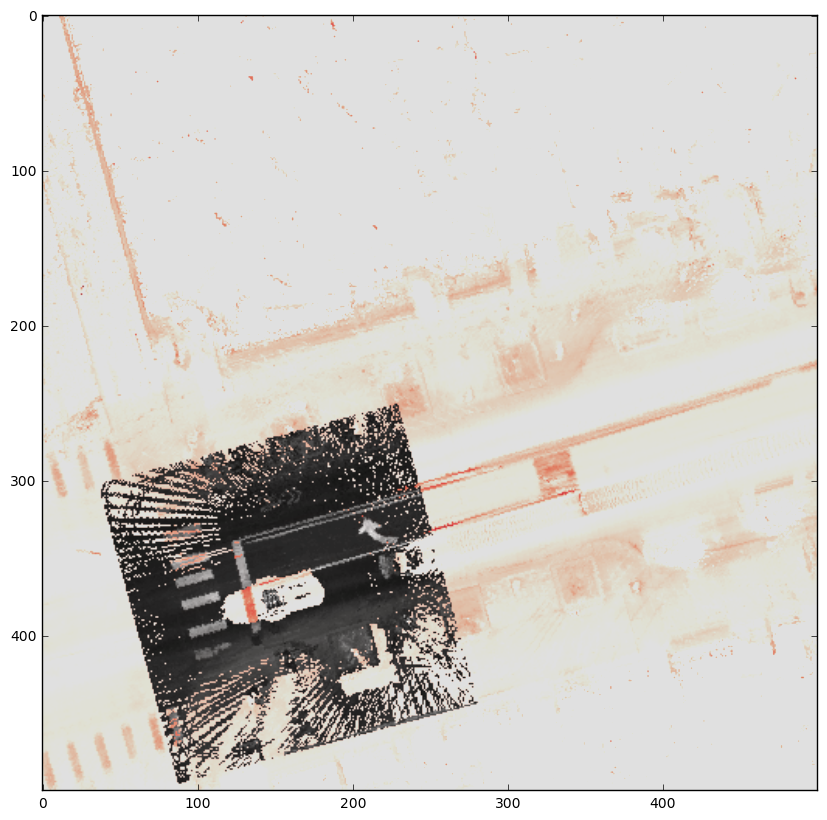

In [185]:
offX = 250 - newX
offY = 750 - newY

prior_map = sample
local_map = np.resize(local[j], (200,200))
local_over_prior_image (prior_map, local_map, target_shape=500, local_shape=200, 
                        offsetX = offX, offsetY = offY, rot = rotateTheta,
                        prior_image=True, inches = (10,10))

In [199]:
#
def augment_prior_map (background_intensity):
    
    number_of_samples = 20
    counter = 0
    prior_maps = np.zeros((20, 500*500))
    ground_truth = np.zeros((20,3))
    
    while counter < number_of_samples:
        
        newTheta = random.randint (0,360)
        edges = get_edges_after_rotation(newTheta)
        
        # Find what all values can x take for this rotation
        # Xmin = Max (X-Intercept with E1 and y=250, X-Intercept with E4 and y=750)
        # Xmax = Min (X-Intercept with E2 and y=250, X-Intercept with E3 and y=750)

        m1 = edges[0,0]
        c1 = edges[1,0]

        m2 = edges[0,1]
        c2 = edges[1,1]

        m3 = edges[0,2]
        c3 = edges[1,2]

        m4 = edges[0,3]
        c4 = edges[1,3]
        
        if np.isnan(m1) or m4 == 0:
            xmin = 0
            xmax = 500
        else:                
            
            x1 = (-250-c1) / m1
            x2 = (-250-c2) / m2
            x3 = (-750-c3) / m3
            x4 = (-750-c4) / m4
    
            xmin = int(max (x1,x4)) + 1
            xmax = int(min (x2, x3)) - 500

        newX = random.randint(xmin, xmax)

        # Use edge E1 and E2 for ymax
        if np.isnan(m1): # m2 also nan
            ymax = -500
        else:
            a = m1*newX + c1
            b = m2*(newX+500) + c2    
            ymax = min(a,b)
            ymax = int(ymax) - 500

        # Use edge E4 and E3 for ymax
        if np.isnan(m3):
            ymin = -1000
        else:
            a = m4 * newX + c4
            b = m3 * (newX+500) + c3 
            ymin = max(a,b)

        if ymin > ymax:
            print ("Invalid combination")
            continue;
            
        # inverting axis here for crop
        ymin = -1*int(ymin)
        ymax = -1*int(ymax)
    
        newY = random.randint(ymax, ymin)

        sample = background_intensity.rotate(newTheta)
        sample = sample.crop((newX, newY-500, newX+500, newY))
        prior_maps[counter][:] = np.array(sample.getdata()).flatten()
        
        ground_truth[counter][:] = [250 - newX, 750 - newY, newTheta]
        counter = counter + 1    

    return prior_maps, ground_truth

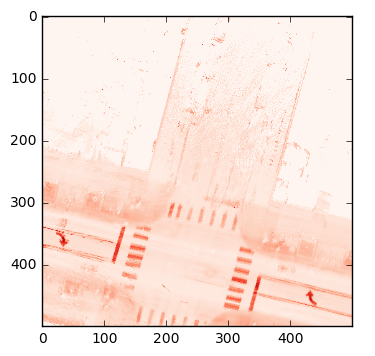

In [195]:
background_intensity = np.resize(prior[j],(1000,1000))
background_intensity = Image.fromarray(np.float64(background_intensity))
prior_maps, ground_truth = augment_prior_map(background_intensity)
prior_map_sample = np.resize(prior_maps[0], (target_shape, target_shape))
img = Image.fromarray(np.uint8(cm.Reds(prior_map_sample)*255))
plt.imshow(img)


In [204]:
prior_index = 7
target_shape = 500
background_intensity = np.resize(prior[j],(1000,1000))
local_map = np.resize(local[j], (200,200))

background_intensity = Image.fromarray(np.float64(background_intensity))
prior_maps, ground_truth = augment_prior_map(background_intensity)
# prior_map_sample = np.resize(prior_maps[prior_index], (target_shape, target_shape))
# img = Image.fromarray(np.uint8(cm.Reds(prior_map_sample)*255))

# offX = int(250 - ground_truth[prior_index][0])
# offY = int(750 - ground_truth[prior_index][1])
# rotateTheta = int(ground_truth[prior_index][2])

f.close()
f = hpy.File("/media/nikhil/d5c833fe-837f-416d-8de3-fb94e14f0de1/localization_dataset/mytestfile.hdf5", "w")
prior_data = f.create_dataset("prior_map", (20,250000), dtype='f')
prior_local_correspondence_data = f.create_dataset("prior_local_correspondence", (20,), dtype='i')
local_data = f.create_dataset("local_map", (1,40000), dtype='f')
y = f.create_dataset("output", (20,3), dtype='i')

prior_data[...] = prior_maps
local_data[...] = local[j]

c = np.empty(20, dtype='i')
c.fill(0)
prior_local_correspondence_data[...] = c

y [...] = ground_truth

# local_over_prior_image (img, local_map, target_shape=500, local_shape=200, 
#                         offsetX = offX, offsetY = offY, rot = rotateTheta,
#                         prior_image=True, inches = (10,10))



# for image_index in range(1000):
#     background_intensity = np.resize(prior[j],(1000,1000))
#     background_intensity = Image.fromarray(np.float64(background_intensity))
#     prior_maps = augement_prior_map (background_intensity)



/
local_map
output
prior_local_correspondence
prior_map
(1, 40000)
(20, 3)
(20,)
(20, 250000)
offsetX: -123
offsetY: 16
theta: 222
(250000, 4)
(250000,)
1188933.03322


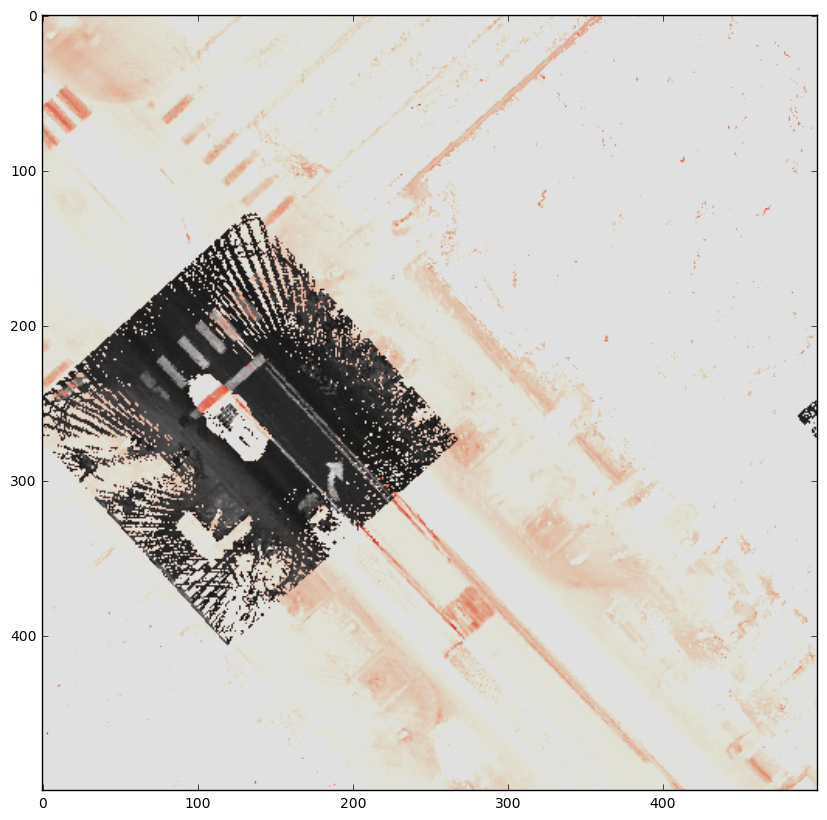

In [211]:
filename = '/media/nikhil/d5c833fe-837f-416d-8de3-fb94e14f0de1/localization_dataset/mytestfile.hdf5'
with hpy.File(filename, 'r') as f:
    print f.name
    for name in f:
        print name
    local_d = f['local_map']
    output_d = f['output']
    corres_d = f['prior_local_correspondence']
    prior_d = f['prior_map']
    
    print local_d.shape
    print output_d.shape
    print corres_d.shape
    print prior_d.shape

    pindex = 19
    lmap = np.resize(local_d[0], (200,200))    
    pmap = np.resize(prior_d[pindex], (500, 500))
    img = Image.fromarray(np.uint8(cm.Reds(pmap)*255))
    offX = output_d[pindex][0]
    offY = output_d[pindex][1]
    rotateTheta = output_d[pindex][2]

    local_over_prior_image (img, lmap, target_shape=500, local_shape=200, 
                        offsetX = offX, offsetY = offY, rot = rotateTheta,
                        prior_image=True, inches = (10,10))


In [220]:
root_dir = '/media/data_raid/dnn_localization/localization_dataset/'
outfile = root_dir + 'annarbor_dataset_dnn_2.hdf5'

with hpy.File(outfile, 'w') as fout:

    prior_data = fout.create_dataset("prior_map", (20*1000,250000), dtype='f')
    prior_local_correspondence_data = fout.create_dataset("prior_local_correspondence", (50*1000,), dtype='i')
    local_data = fout.create_dataset("local_map", (1*1000,40000), dtype='f')
    y = fout.create_dataset("output", (50*1000,3), dtype='i')
    
    for image_index in range(1000):

        background_intensity = np.resize(prior[image_index],(1000,1000))
        background_intensity = Image.fromarray(np.float64(background_intensity))
        prior_maps, ground_truth = augment_prior_map(background_intensity)        
        data_index = image_index*20

        prior_data[data_index:data_index+20] = prior_maps
        local_data[image_index] = local[image_index]

        c = np.empty(20, dtype='i')
        c.fill(image_index)
        prior_local_correspondence_data[data_index:data_index+20] = c

        y [data_index:data_index+20] = ground_truth
        
        if image_index % 100 == 0:
            print image_index

        


0
100
200
300
400
500
600
700
800
900


/
local_map
output
prior_local_correspondence
prior_map
(999, 40000)
(50000, 3)
(49950,)
(49950, 250000)
(200, 200, 4)


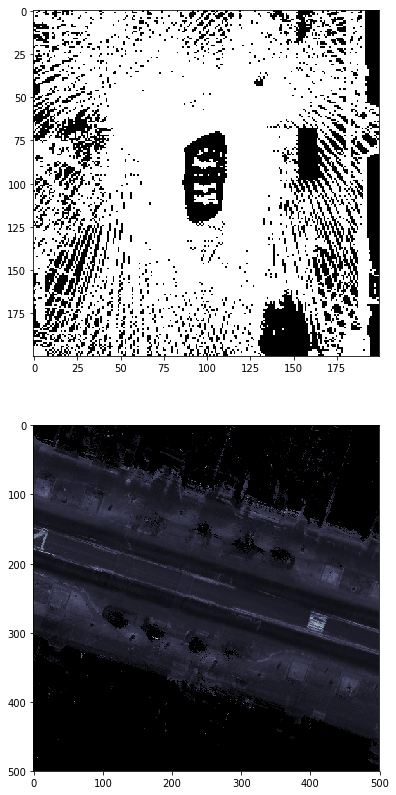

In [11]:
# root_dir = '/media/nikhil/d5c833fe-837f-416d-8de3-fb94e14f0de1/localization_dataset/'
root_dir = '/media/data_raid/dnn_localization/localization_dataset/'
outfile = root_dir + 'annarbor_dataset_dnn_1.hdf5'

with hpy.File(outfile, 'r') as fout:
    print fout.name
    for name in fout:
        print name

    local_d = fout['local_map']
    output_d = fout['output']
    corres_d = fout['prior_local_correspondence']
    prior_d = fout['prior_map']
    
    print local_d.shape
    print output_d.shape
    print corres_d.shape
    print prior_d.shape

#     pindex = 6785
    pindex = 13090
#     pindex = 15914
#     pindex = 5019

    corres = corres_d[pindex]

    lmap = np.resize(local_d[corres], (200,200))    
    pmap = np.resize(prior_d[pindex], (500, 500))

# Simple visualization

    fig = plt.gcf()
    inches = (14,14)
    fig.set_size_inches(inches[0], inches[1])

#     print lmap
    lmap = np.uint8(cm.bone(lmap*1000000)*255)    
    print lmap.shape
#     print lmap
    lmap = Image.fromarray(lmap)
    pmap = Image.fromarray(np.uint8(cm.bone(pmap)*255))
    
    plt.subplot(211)
    plt.imshow(lmap)
    
    plt.subplot(212)
    plt.imshow(pmap)
    
#Overlay Code
#     img = Image.fromarray(np.uint8(cm.Reds(pmap)*255))
    
#     offX = output_d[pindex][0]
#     offY = output_d[pindex][1]
#     rotateTheta = output_d[pindex][2]

#     local_over_prior_image (img, lmap, target_shape=500, local_shape=200, 
#                         offsetX = offX, offsetY = offY, rot = rotateTheta,
#                         prior_image=True, inches = (10,10))
